# Install Packages

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import json
from shapely.validation import make_valid
import warnings

# Read Files

In [3]:
data = pd.read_json("../data/cleaned/BusRoutes.json", encoding="utf-8", lines=True, chunksize=1000)

# Combine chunks into a dataframe
df_list = []
for chunk in data:
    df_list.append(chunk)

# Concatenate all chunks into a single dataframe
bus_routes = pd.concat(df_list, ignore_index=True)
bus_routes = bus_routes[bus_routes['Direction']==1]
bus_routes = bus_routes[['ServiceNo', 'BusStopCode', 'StopSequence', 'Distance']]
print(bus_routes.head())

  ServiceNo  BusStopCode  StopSequence  Distance
0        10        75009             1       0.0
1        10        76059             2       0.6
2        10        76069             3       1.1
3        10        96289             4       2.3
4        10        96109             5       2.7


In [4]:
# Load BusStops.geojson using GeoPandas
bus_stops = gpd.read_file('../data/cleaned/BusStops.geojson').to_crs(32648)
print(bus_stops.head())

   BUS_STOP_N BUS_ROOF_N         LOC_DESC                       geometry
0       65059        B12     ST ANNE'S CH   POINT (377770.78 154000.188)
1       16171        B06  YUSOF ISHAK HSE  POINT (363642.782 143603.062)
2       61101        NIL          BLK 120  POINT (373583.973 147657.504)
3        1239        B01     SULTAN PLAZA   POINT (373353.81 144032.943)
4       17269        B01          BLK 730  POINT (362337.597 144267.297)


In [5]:
rail_line = gpd.read_file('../data/cleaned/RailLines.geojson').to_crs(32648)
print(rail_line.head())

    Name                                        Description  GroundLevel  \
0  kml_1  <center><table><tr><th colspan='2' align='cent...  ABOVEGROUND   
1  kml_2  <center><table><tr><th colspan='2' align='cent...  ABOVEGROUND   
2  kml_3  <center><table><tr><th colspan='2' align='cent...  ABOVEGROUND   
3  kml_4  <center><table><tr><th colspan='2' align='cent...  ABOVEGROUND   
4  kml_5  <center><table><tr><th colspan='2' align='cent...  ABOVEGROUND   

  RailType                                           geometry  
0      MRT  LINESTRING Z (359431.624 149585.058 0, 359430....  
1      MRT  LINESTRING Z (359496.358 149434.165 0, 359562....  
2      MRT  LINESTRING Z (356848.064 149532.756 0, 356847....  
3      MRT  LINESTRING Z (356839.113 149546.331 0, 356837....  
4      MRT  LINESTRING Z (356223.133 149130.489 0, 356223....  


In [6]:
rail_stn = gpd.read_file('../data/cleaned/RailStationsMerged.geojson').to_crs(32648)
print(rail_stn.head())

      Name                                        Description StationType  \
0  kml_105  <center><table><tr><th colspan='2' align='cent...         MRT   
1  kml_154  <center><table><tr><th colspan='2' align='cent...         MRT   
2    kml_1  <center><table><tr><th colspan='2' align='cent...         MRT   
3  kml_163  <center><table><tr><th colspan='2' align='cent...         MRT   
4  kml_243  <center><table><tr><th colspan='2' align='cent...         MRT   

      StationName StationCode    StationLine  \
0       Admiralty        NS10    North-South   
1        Aljunied         EW9      East-West   
2      Ang Mo Kio        NS16    North-South   
3   Aviation Park         CR2   Cross Island   
4  Bahar Junction         JS7  Jurong Region   

                                            geometry  
0  POLYGON Z ((366516.031 159202.829 0, 366504.93...  
1  POLYGON Z ((375812.204 145533.073 0, 375813.17...  
2  POLYGON Z ((372048.497 151373.847 0, 372034.48...  
3  POLYGON Z ((388984.94 151

# Data Cleaning : Obtain  Bus Line Strings

In [7]:
## Merge Bus Stop Coordinates with Bus Routes
# Ensure that BusStopCode is of the same type for both DataFrames (string)
bus_stops['BusStopCode'] = bus_stops['BUS_STOP_N'].astype(str)
bus_routes['BusStopCode'] = bus_routes['BusStopCode'].astype(str)

# Merge bus_routes with bus_stops to get geometry for each bus stop
merged_bus_data = bus_routes.merge(bus_stops[['BusStopCode', 'geometry']], on='BusStopCode', how='left')

# Drop rows without geometry
merged_bus_data = merged_bus_data.dropna(subset=['geometry'])

# Convert to GeoDataFrame
bus_routes_geo = gpd.GeoDataFrame(merged_bus_data, geometry='geometry')
# bus_routes_geo.to_crs(3857)
bus_routes_geo.set_crs(epsg=32648, inplace=True,allow_override=True)
bus_routes_geo.head()

,ServiceNo,BusStopCode,StopSequence,Distance,geometry
0,10,75009,1,0.0,POINT (382479.99 149772.212)
1,10,76059,2,0.6,POINT (382257.146 149576.907)
2,10,76069,3,1.1,POINT (382307.904 149087.517)
3,10,96289,4,2.3,POINT (383004.155 148143.843)
4,10,96109,5,2.7,POINT (383262.649 147839.518)


# Segment Bus Routes by LineString


  ServiceNo                                           geometry
0        10  LINESTRING (382479.99 149772.212, 382257.146 1...
1       100  LINESTRING (374479.342 149295.696, 374511.914 ...
2      100A  LINESTRING (374479.342 149295.696, 374511.914 ...
3       101  LINESTRING (374479.342 149295.696, 374602.888 ...
4       102  LINESTRING (376740.13 151559.417, 377110.624 1...


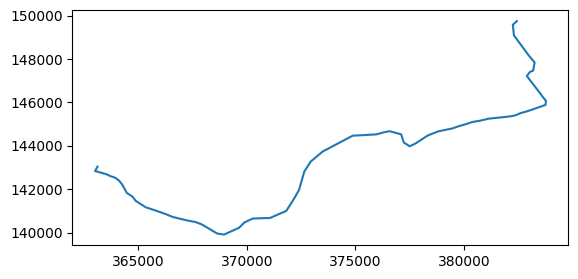

In [8]:
bus_routes_lines = (
    bus_routes_geo.groupby(['ServiceNo'])
    .apply(lambda x: LineString(x.sort_values('StopSequence')['geometry'].tolist()))
    .reset_index()
    .rename(columns={0: 'geometry'})
)
# Convert to GeoDataFrame
bus_routes_lines = gpd.GeoDataFrame(bus_routes_lines, geometry='geometry')
bus_routes_lines = bus_routes_lines.set_crs(epsg=32648)
print(bus_routes_lines.head())

bs10 = bus_routes_lines[bus_routes_lines['ServiceNo']=='10']

bs10.plot()
plt.show()

# Visualise Bus Segments

[<LINESTRING (382479.99 149772.212, 382433.572 148917.191)>, <LINESTRING (382433.572 148917.191, 383029.365 148114.162)>, <LINESTRING (383029.365 148114.162, 382985.657 147324.761)>, <LINESTRING (382985.657 147324.761, 383429.033 146530.459)>, <LINESTRING (383429.033 146530.459, 383545.178 145805.014)>, <LINESTRING (383545.178 145805.014, 382594.422 145496.484)>, <LINESTRING (382594.422 145496.484, 381621.979 145298.007)>, <LINESTRING (381621.979 145298.007, 380636.986 145135.189)>, <LINESTRING (380636.986 145135.189, 379675.138 144869.186)>, <LINESTRING (379675.138 144869.186, 378709.364 144619.358)>, <LINESTRING (378709.364 144619.358, 377835.07 144144.303)>, <LINESTRING (377835.07 144144.303, 377137.661 144439.482)>, <LINESTRING (377137.661 144439.482, 376227.297 144595.115)>, <LINESTRING (376227.297 144595.115, 375238.054 144481.901)>, <LINESTRING (375238.054 144481.901, 374312.143 144165.987)>, <LINESTRING (374312.143 144165.987, 373436.091 143686.869)>, <LINESTRING (373436.091 14

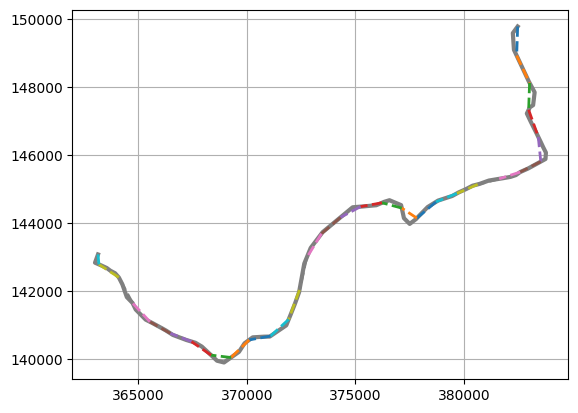

In [9]:
def segment_line_by_distance(line, distance=1000):
    segments = []  # List to store the line segments
    current_distance = 0  # Start distance

    # Iterate over the entire length of the line and create segments of the specified distance
    while current_distance < line.length:
        # Calculate the start and end points for each segment
        start_point = line.interpolate(current_distance)
        end_point = line.interpolate(min(current_distance + distance, line.length))
        
        # Create a LineString for the segment and add it to the list
        segments.append(LineString([start_point, end_point]))
        
        # Move to the next segment
        current_distance += distance

    return segments  # Return the list of 1 km line segments

# Segment the line by 1 km distance
bs10_segmented = segment_line_by_distance(bs10.geometry.iloc[0], 1000)
print(bs10_segmented)
# plot orignal bus line
x, y = bs10.geometry.iloc[0].xy  # Extract x and y coordinates for the original line
plt.plot(x, y, color='gray', linewidth=3, label='Original Bus Line')

# plot segmented bus line
for segment in bs10_segmented:
    x_seg, y_seg = segment.xy  # Extract x and y coordinates for the segment
    plt.plot(x_seg, y_seg, linewidth=2, linestyle='--')

# Show the plot
plt.grid(True)
plt.show()

# Create MRT Line String with MRT Stations

In [10]:
rail_stn = rail_stn.to_crs(epsg=32648)

#  Group the stations by MRT line
rail_stn.drop(rail_stn[rail_stn['StationCode']=='PTC'].index, inplace=True)
rail_stn.drop(rail_stn[rail_stn['StationCode']=='STC'].index, inplace=True)
rail_stn.replace("TE22A", "TE22.5", inplace=True)
station_groups = rail_stn.groupby('StationLine')

# Dictionary to store LineStrings for each MRT line
line_strings_per_station_line = {}

# Iterate over each MRT line group and create a sorted LineString
for line_name, group in station_groups:
    # Sort the stations by their longitude (x-coordinate) or latitude (y-coordinate)
    group['centroid_x'] = group.geometry.centroid.x  # Get x-coordinate of the centroid
    group['StationCodeNo'] = group['StationCode'].str[2:].astype(float)
    sorted_group = group.sort_values('StationCodeNo')  # Sort by the x-coordinate

    # Extract the station centroids, names, and codes
    station_points = sorted_group.geometry.centroid.tolist()
    station_names = sorted_group['StationName'].tolist()
    station_codes = sorted_group['StationCode'].tolist()

    # Initialize a set to track unique station codes
    unique_station_codes = set()

    # Initialize lists to store filtered stations (with unique codes)
    filtered_station_points = []
    filtered_station_names = []
    filtered_station_codes = []

    #Filter out stations with duplicate station codes and None values
    for point, name, code in zip(station_points, station_names, station_codes):
        if code not in unique_station_codes and point is not None:
            # Add the station to the filtered lists
            filtered_station_points.append(point)
            filtered_station_names.append(name)
            filtered_station_codes.append(code)

            # Mark this station code as seen
            unique_station_codes.add(code)

    # create a LineString from the filtered station points
    if filtered_station_points:  # Check if we have valid points
        try:
            mrt_line = LineString(filtered_station_points)
        
            # Store the data in the dictionary
            line_strings_per_station_line[line_name] = {
                'LineString': mrt_line,
                'StationNames': filtered_station_names,
                'StationCodes': filtered_station_codes,
                'StationPoints': filtered_station_points
            }
        except TypeError as e:
            print(f"Error creating LineString for {line_name}: {e}")
            continue

print(line_strings_per_station_line)
for line_name, line_data in line_strings_per_station_line.items():
    print(f"MRT Line: {line_name}")
    print(f"  LineString: {line_data['LineString']}")
    print(f"  Station Names: {line_data['StationNames']}")
    print(f"  Station Codes: {line_data['StationCodes']}")
    print(f"  Station Points (centroids): {line_data['StationPoints']}")
    print("\n")

{'Bukit Panjang LRT': {'LineString': <LINESTRING (360309.027 153140.435, 360411.414 152601.551, 360829.656 152414...>, 'StationNames': ['Choa Chu Kang', 'South View', 'Keat Hong', 'Teck Whye', 'Phoenix', 'Bukit Panjang', 'Petir', 'Pending', 'Bangkit', 'Fajar', 'Segar', 'Senja'], 'StationCodes': ['BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'BP8', 'BP9', 'BP10', 'BP11', 'BP13'], 'StationPoints': [<POINT (360309.027 153140.435)>, <POINT (360411.414 152601.551)>, <POINT (360829.656 152414.918)>, <POINT (361346.739 152198.743)>, <POINT (361829.093 152415.808)>, <POINT (362235.186 152463.085)>, <POINT (362789.705 152319.091)>, <POINT (363302.833 152138.828)>, <POINT (363456.769 152568.697)>, <POINT (363254.156 153068.205)>, <POINT (363123.233 153424.677)>, <POINT (362311.693 152865.997)>]}, 'Circle': {'LineString': <LINESTRING (371555.63 143685.879, 373066.751 141713.911, 372568.151 141121....>, 'StationNames': ['Dhoby Ghaut', 'Bayfront', 'Marina Bay', 'Bras Basah', 'Esplanade', 'Promen

# Visualise MRT Line String

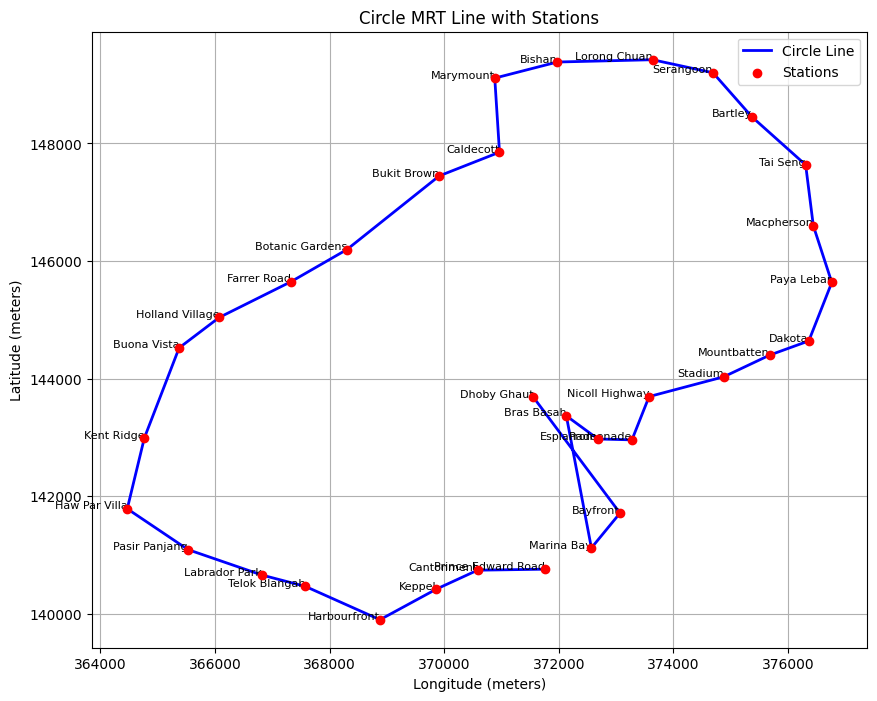

In [11]:

target_line = "Circle" #change accordingly

# Check if the line exists in the processed data
if target_line in line_strings_per_station_line:
    line_data = line_strings_per_station_line[target_line]

    # Extract the LineString, station points, and station names
    mrt_line = line_data['LineString']
    station_points = line_data['StationPoints']
    station_names = line_data['StationNames']

    # Plot the MRT line
    plt.figure(figsize=(10, 8))
    
    # Plot the LineString representing the MRT line
    x, y = mrt_line.xy  # Extract x and y coordinates from the LineString
    plt.plot(x, y, label=f'{target_line} Line', color='blue', linewidth=2)
    
    # Plot the station points on the map
    station_x = [point.x for point in station_points]
    station_y = [point.y for point in station_points]
    plt.scatter(station_x, station_y, color='red', label='Stations', zorder=5)

    # Annotate the station names
    for i, name in enumerate(station_names):
        plt.text(station_x[i], station_y[i], name, fontsize=8, ha='right')

    # Set the title and labels
    plt.title(f'{target_line} MRT Line with Stations')
    plt.xlabel('Longitude (meters)')
    plt.ylabel('Latitude (meters)')
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.grid(True)
    plt.show()

else:
    print(f"No data available for MRT Line: {target_line}")


# Segment MRT Stations

In [12]:
# Function to segment a LineString into 1 km sections
def segment_line_by_distance(line, distance=1000):
    segments = []  # List to store the line segments
    current_distance = 0  # Start distance

    # Iterate over the entire length of the line and create segments of the specified distance
    while current_distance < line.length:
        # Calculate the start and end points for each segment
        start_point = line.interpolate(current_distance)
        end_point = line.interpolate(min(current_distance + distance, line.length))
        
        # Create a LineString for the segment and add it to the list
        segments.append(LineString([start_point, end_point]))
        
        # Move to the next segment
        current_distance += distance

    return segments  # Return the list of 1 km line segments

# Dictionary to store segmented lines for each MRT line
segmented_lines_per_station_line = {}

# Iterate through each MRT line in the dataset
for line_name, line_info in line_strings_per_station_line.items():
    # Get the LineString and station details for each line
    mrt_line = line_info['LineString']
    station_points = line_info['StationPoints']
    station_names = line_info['StationNames']

    # Segment the MRT line into 1 km sections
    mrt_segments = segment_line_by_distance(mrt_line, 1000)

    # Store the segments for this MRT line
    segmented_lines_per_station_line[line_name] = {
        'segments': mrt_segments,
        'station_names': station_names,
        'station_points': station_points
    }


# Visualise MRT Segments

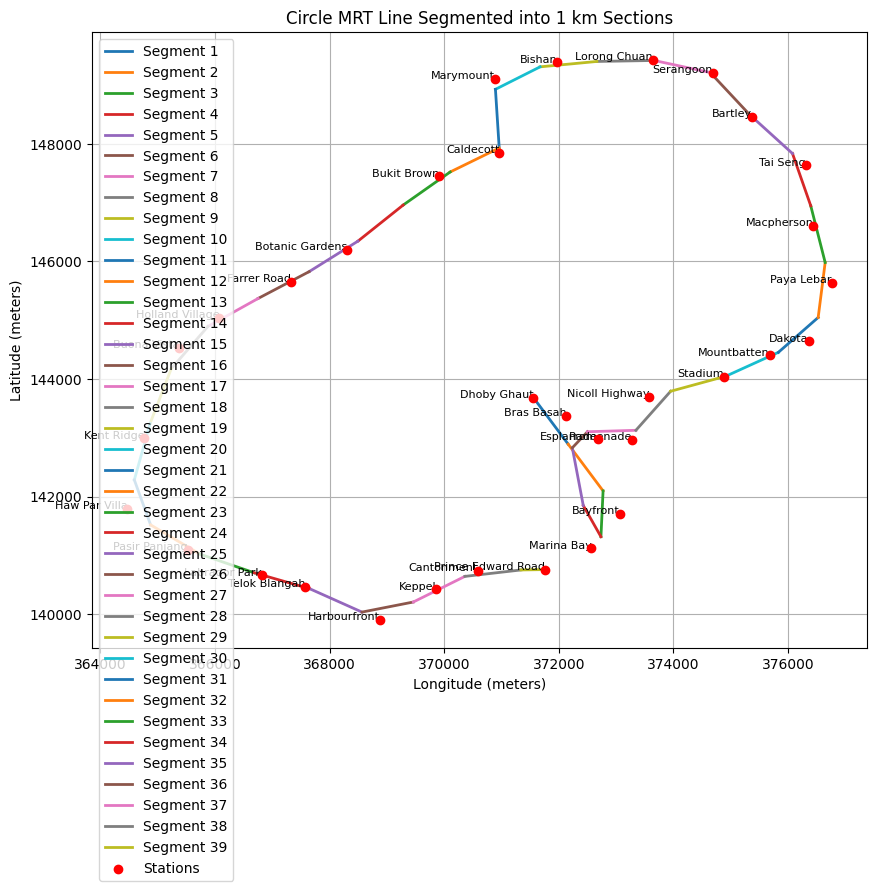

Segment 1: LINESTRING (371555.6297982114 143685.87893660585, 372163.8786611015 142892.13255343746)
Segment 2: LINESTRING (372163.8786611015 142892.13255343746, 372772.12752399157 142098.38617026908)
Segment 3: LINESTRING (372772.12752399157 142098.38617026908, 372734.59347757563 141319.53215010735)
Segment 4: LINESTRING (372734.59347757563 141319.53215010735, 372426.4709542468 141849.87776272112)
Segment 5: LINESTRING (372426.4709542468 141849.87776272112, 372235.43128773646 142831.46008011463)


In [13]:
target_line = "Circle"  # change to visualize other lines
if target_line in segmented_lines_per_station_line:
    segmented_data = segmented_lines_per_station_line[target_line]

    mrt_segments = segmented_data['segments']
    station_points = segmented_data['station_points']
    station_names = segmented_data['station_names']

    # Visualize the segments on the map
    plt.figure(figsize=(10, 8))

    # Plot each segment in a different color
    for idx, segment in enumerate(mrt_segments):
        x_seg, y_seg = segment.xy  # Extract x and y coordinates for the segment
        plt.plot(x_seg, y_seg, label=f'Segment {idx+1}', linewidth=2)

    # Plot the station points
    station_x = [point.x for point in station_points]
    station_y = [point.y for point in station_points]
    plt.scatter(station_x, station_y, color='red', label='Stations', zorder=5)

    # Annotate the station names
    for i, name in enumerate(station_names):
        plt.text(station_x[i], station_y[i], name, fontsize=8, ha='right')

    # Set the title and labels
    plt.title(f'{target_line} MRT Line Segmented into 1 km Sections')
    plt.xlabel('Longitude (meters)')
    plt.ylabel('Latitude (meters)')

    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.grid(True)
    plt.show()

    # Print the first few segments for verification
    for idx, segment in enumerate(mrt_segments[:5]):  # Print first 5 segments
        print(f"Segment {idx+1}: {segment}")

else:
    print(f"No data available for MRT Line: {target_line}")

# PHASE 1: Conduct Initial Checks for Distance Proximity
Compare the bus route's entire geometry with the MRT line to check if they are near in distance. If there's no overlap, discard that bus route.
Reduces the number of comparisons needed.

In [14]:
# Define buffer distance
buffer_distance = 500

In [15]:
if bus_routes_lines.crs is None:
    bus_routes_lines = bus_routes_lines.set_crs(epsg=4326)

#Reproject bus routes to the same CRS as the MRT lines (UTM Zone 48N - EPSG:32648)
bus_routes_lines = bus_routes_lines.to_crs(epsg=32648)

mrt_buffers = {}  # Dictionary to store buffers for each MRT line

for line_name, line_data in line_strings_per_station_line.items():
    mrt_line = line_data['LineString']
    mrt_buffer = mrt_line.buffer(buffer_distance)  # Create a buffer around the MRT line
    mrt_buffers[line_name] = mrt_buffer  # Store the buffer

#Check if any bus route is near any MRT line buffer
overlap_results = []

for line_name, mrt_buffer in mrt_buffers.items():
    for idx, bus_route in bus_routes_lines.iterrows():
        if bus_route.geometry.intersects(mrt_buffer):
            overlap_length = bus_route.geometry.intersection(mrt_buffer).length  # Get overlap length
            overlap_results.append({
                'MRT_Line': line_name,
                'Bus_ServiceNo': bus_route['ServiceNo'],
                'Bus_Route_Length_m': bus_route.geometry.length,  # Length of the bus route in meters
                'Overlap_Length_m': overlap_length  # Overlap length in meters
            })

overlap_df = pd.DataFrame(overlap_results)

#Sort the DataFrame by 'Overlap_Length_m' in descending order
overlap_df_sorted = overlap_df.sort_values(by='Overlap_Length_m', ascending=False)

# For each bus service, keep only the direction with the greater overlap
# Group by 'Bus_ServiceNo' and 'Direction', take the max 'Overlap_Length_m' for each service
overlap_df_max = overlap_df_sorted.groupby(['Bus_ServiceNo']).apply(lambda x: x.loc[x['Overlap_Length_m'].idxmax()]).reset_index(drop=True)

# Drop duplicates for each 'Bus_ServiceNo' while keeping only the row with the maximum 'Overlap_Length_m'
overlap_df_unique = overlap_df_max.sort_values(by='Overlap_Length_m', ascending=False).drop_duplicates(subset=['Bus_ServiceNo'], keep='first')

# Output the final DataFrame
overlap_df_unique



,MRT_Line,Bus_ServiceNo,Bus_Route_Length_m,Overlap_Length_m
457,Cross Island,89,38696.750127,23378.554596
340,East-West,63,33442.621667,22452.059977
268,Thomson East Coast,36,44616.364459,22222.688024
187,East-West,24,45129.781783,22094.798253
372,Circle,70M,39038.921802,21335.866347
...,...,...,...,...
117,North-South,170X,4195.958615,576.607900
365,Downtown,68A,1894.746553,576.581582
465,Thomson East Coast,902,551.485014,551.485014
506,North-South,962C,1250.818701,402.658208


# PHASE 2.1: Segment Coverage Calculation for Bus Routes and MRT Line Segments
To determine how much of an MRT line's segments are covered by a bus route. The MRT lines are segmented into equal parts, and we check which of these segments overlap with the corresponding bus route. This analysis helps us assess how parallel the bus route is to the MRT line in terms of spatial coverage.

Steps:

Segmentation: Each MRT line is divided into segments of a fixed length. These segments represent portions of the MRT line.

Intersection Check: For each bus route, we check how many of the MRT segments it intersects. This is done by comparing the geometry of the bus route with each MRT segment.

Coverage Calculation: We calculate the percentage of MRT segments that are covered by the bus route:

In [16]:
# Initialize a list to store the results
segment_coverage_results = []

# Iterate through each row in overlap_df_unique
for idx, row in overlap_df_unique.iterrows():
    # Fetch the geometry of the bus route (LineString) based on ServiceNo and Direction
    bus_geometry = bus_routes_lines.loc[
        (bus_routes_lines['ServiceNo'] == row['Bus_ServiceNo'])
    ].geometry.iloc[0]
    
    # Fetch the MRT Line geometry
    mrt_line = line_strings_per_station_line[row['MRT_Line']]['LineString']
    
    # Segment the MRT line 
    mrt_segments = segment_line_by_distance(mrt_line, 1000)  # EDIT

    # Calculate how many segments are covered by the bus route
    total_segments = len(mrt_segments)
    covered_segments = 0

    for segment in mrt_segments:
        if bus_geometry.intersects(segment):  # Check if the bus route intersects the MRT segment
            covered_segments += 1

    # Calculate the percentage of MRT segments covered by the bus route
    coverage_percentage = (covered_segments / total_segments) * 100 if total_segments > 0 else 0
    
    # Append the result to the list
    segment_coverage_results.append({
        'MRT_Line': row['MRT_Line'],
        'Bus_ServiceNo': row['Bus_ServiceNo'],
        'Bus_Route_Length_m': row['Bus_Route_Length_m'],
        'Overlap_Length_m': row['Overlap_Length_m'],
        'Coverage_Percentage': coverage_percentage
    })

# Convert the results to a DataFrame
segment_coverage_df = pd.DataFrame(segment_coverage_results)

# Filter the DataFrame to only include rows with a Coverage_Percentage > 0
segment_coverage_df_filtered = segment_coverage_df[segment_coverage_df['Coverage_Percentage'] > 0]

# Sort by coverage percentage in descending order
segment_coverage_df_sorted = segment_coverage_df_filtered.sort_values(by='Coverage_Percentage', ascending=False)

# Output the final DataFrame
segment_coverage_df_sorted

,MRT_Line,Bus_ServiceNo,Bus_Route_Length_m,Overlap_Length_m,Coverage_Percentage
277,Punggol LRT,84G,5175.941134,5175.941134,50.000000
93,Bukit Panjang LRT,972M,36598.676848,9644.545486,50.000000
171,Bukit Panjang LRT,976,7464.432230,7163.349917,50.000000
42,Sengkang LRT,102,22426.851650,12151.366763,50.000000
212,Bukit Panjang LRT,975,33732.482499,6302.597549,50.000000
...,...,...,...,...,...
264,East-West,35M,14598.777922,5502.529997,1.666667
324,East-West,248,19553.118779,4693.315985,1.666667
219,East-West,201,14472.384060,6184.410752,1.666667
131,East-West,99,14720.703256,8187.283549,1.666667


In [17]:
import pandas as pd
from shapely.geometry import Point, LineString

def find_similar_bus_routes(bus_routes_lines, mrt_stations_df, target_service_no, segment_distance=1000):
    """
    Find bus routes similar to a given target bus route based on spatial overlap and shared MRT stations.
    
    Parameters:
    - bus_routes_lines: DataFrame containing bus routes with 'ServiceNo' and 'geometry' columns.
    - mrt_stations_df: DataFrame containing MRT stations with 'StationCode', 'geometry', and relevant line data.
    - target_service_no: The service number of the target bus route to query for similar routes.
    - segment_distance: The distance (in meters) for segmenting each bus route.
    
    Returns:
    - A DataFrame with bus routes that have a high degree of spatial overlap with the target bus route
      and intersect with the same MRT stations.
    """
    
    # Verify necessary columns
    if 'ServiceNo' not in bus_routes_lines.columns or 'geometry' not in bus_routes_lines.columns:
        raise ValueError("bus_routes_lines must have 'ServiceNo' and 'geometry' columns.")
    
    if 'geometry' not in mrt_stations_df.columns:
        raise ValueError("mrt_stations_df must have a 'geometry' column for station locations.")
    
    # Initialize a list to store the results
    bus_route_similarity_results = []

    # Fetch the target bus route geometry
    target_row = bus_routes_lines[bus_routes_lines['ServiceNo'] == target_service_no]
    if target_row.empty:
        return f"Bus route {target_service_no} not found in the dataset."
    
    target_geometry = target_row.geometry.iloc[0]
    target_segments = segment_line_by_distance(target_geometry, segment_distance)

    # Identify MRT stations that intersect with the target bus route
    intersecting_stations = mrt_stations_df[mrt_stations_df.geometry.intersects(target_geometry)]
    intersecting_station_geoms = intersecting_stations['geometry'].tolist()

    # Iterate through other bus routes to compare with the target bus route
    for idx, compare_row in bus_routes_lines.iterrows():
        compare_service_no = compare_row['ServiceNo']
        
        # Skip if comparing the same route
        if compare_service_no == target_service_no:
            continue
        
        # Fetch the geometry of the comparison bus route and segment it
        compare_geometry = compare_row.geometry
        compare_segments = segment_line_by_distance(compare_geometry, segment_distance)

        # Calculate the number of segments that intersect with the target route
        total_segments = len(target_segments)
        covered_segments = 0
        
        for target_segment in target_segments:
            for compare_segment in compare_segments:
                if target_segment.intersects(compare_segment):
                    covered_segments += 1
                    break  # Move to the next target segment once a match is found

        # Calculate the coverage percentage for route segments
        route_coverage_percentage = (covered_segments / total_segments) * 100 if total_segments > 0 else 0

        # Calculate the number of intersecting MRT stations
        shared_stations = sum(compare_geometry.intersects(station_geom) for station_geom in intersecting_station_geoms)
        station_coverage_percentage = (shared_stations / len(intersecting_station_geoms)) * 100 if intersecting_station_geoms else 0

        # Combine segment coverage and station coverage into a final score (adjust weighting as needed)
        final_coverage_score = (0.7 * route_coverage_percentage) + (0.3 * station_coverage_percentage)

        # Append the result to the list
        bus_route_similarity_results.append({
            'Target_Bus_ServiceNo': target_service_no,
            'Comparison_Bus_ServiceNo': compare_service_no,
            'Target_Route_Length_m': target_geometry.length,
            'Comparison_Route_Length_m': compare_geometry.length,
            'Route_Coverage_Percentage': route_coverage_percentage,
            'Station_Coverage_Percentage': station_coverage_percentage,
            'Final_Coverage_Score': final_coverage_score
        })

    # Convert the results to a DataFrame
    bus_route_similarity_df = pd.DataFrame(bus_route_similarity_results)

    # Filter the DataFrame to only include rows with a positive Final Coverage Score
    bus_route_similarity_df_filtered = bus_route_similarity_df[bus_route_similarity_df['Final_Coverage_Score'] > 0]

    # Sort by final coverage score in descending order
    bus_route_similarity_df_sorted = bus_route_similarity_df_filtered.sort_values(by='Final_Coverage_Score', ascending=False)

    # Return the final sorted DataFrame
    return bus_route_similarity_df_sorted

def segment_line_by_distance(line, segment_distance):
    """
    Splits a LineString into segments of a specified distance.

    Parameters:
    - line: A LineString geometry object.
    - segment_distance: Distance for each segment.

    Returns:
    - List of LineString segments.
    """
    if not isinstance(line, LineString):
        raise ValueError("Input geometry must be a LineString.")
    
    points = [line.interpolate(distance) for distance in range(0, int(line.length), segment_distance)]
    segments = [LineString([points[i], points[i + 1]]) for i in range(len(points) - 1)]
    
    return segments



In [18]:
def find_potential_mrt_lines(bus_routes_df, mrt_lines_df, target_service_no, buffer_distance=500):
    """
    Identify potential MRT lines that intersect or run parallel to a specified bus route.
    
    Parameters:
    - bus_routes_df: DataFrame containing bus routes with 'ServiceNo' and 'geometry' columns.
    - mrt_lines_df: DataFrame containing MRT lines with 'StationLine' and 'geometry' columns.
    - target_service_no: The service number of the bus route to analyze.
    - buffer_distance: The buffer distance (in meters) to consider an MRT line as parallel or intersecting.
    
    Returns:
    - A DataFrame of MRT lines that intersect or are within proximity to the bus route.
    """
    # Fetch the target bus route geometry
    target_row = bus_routes_df[bus_routes_df['ServiceNo'] == target_service_no]
    if target_row.empty:
        return f"Bus route {target_service_no} not found in the dataset."
    
    target_geometry = target_row.geometry.iloc[0]
    
    # Create a buffer around the bus route to check for nearby MRT lines
    bus_route_buffer = target_geometry.buffer(buffer_distance)

    # Initialize a list to store results
    potential_mrt_lines = []

    # Iterate over MRT lines to check for intersections or proximity
    for _, mrt_line in mrt_lines_df.iterrows():
        mrt_geometry = mrt_line['geometry']
        
        if bus_route_buffer.intersects(mrt_geometry):
            overlap_length = bus_route_buffer.intersection(mrt_geometry).length
            potential_mrt_lines.append({
                'Bus_ServiceNo': target_service_no,
                'MRT_Line': mrt_line['StationLine'],
                'MRT_Line_Length_m': mrt_geometry.length,
                'Overlap_Length_m': overlap_length
            })

    # Convert results to DataFrame
    potential_mrt_lines_df = pd.DataFrame(potential_mrt_lines)

    # Sort by overlap length in descending order
    potential_mrt_lines_df_sorted = potential_mrt_lines_df.sort_values(by='Overlap_Length_m', ascending=False)
    
    return potential_mrt_lines_df_sorted

In [19]:
potential_mrt_lines_df = find_potential_mrt_lines(bus_routes_lines, rail_stn, '124')
print(list(potential_mrt_lines_df['MRT_Line'].unique()))

['Circle', 'Thomson East Coast', 'North-South', 'East-West', 'North-East', 'Downtown']


In [20]:
# Assuming bus_routes_lines DataFrame and segment_line_by_distance function are already defined
similar_routes_df = find_similar_bus_routes(bus_routes_lines, rail_stn, '124')
print(similar_routes_df)


    Target_Bus_ServiceNo Comparison_Bus_ServiceNo  Target_Route_Length_m  \
149                  124                      190           15816.565389   
107                  124                      167           15816.565389   
122                  124                     174e           15816.565389   
308                  124                      502           15816.565389   
121                  124                      174           15816.565389   
..                   ...                      ...                    ...   
155                  124                      195           15816.565389   
367                  124                        7           15816.565389   
67                   124                       14           15816.565389   
160                  124                      197           15816.565389   
428                  124                     857B           15816.565389   

     Comparison_Route_Length_m  Route_Coverage_Percentage  \
149               19917.25

In [21]:
def calculate_coverage(bus_route_geometry, mrt_line_geometry, buffer_distance=500, segment_distance=1000):
    # Segment the bus route
    bus_segments = segment_line_by_distance(bus_route_geometry, segment_distance)
    
    # Calculate coverage percentage with MRT line segments
    covered_segments = 0
    for bus_segment in bus_segments:
        if bus_segment.buffer(buffer_distance).intersects(mrt_line_geometry):
            covered_segments += 1
    
    # Calculate coverage percentage
    coverage_percentage = (covered_segments / len(bus_segments)) * 100 if bus_segments else 0
    return coverage_percentage


In [22]:
def evaluate_nearby_bus_stops(bus_stops_df, mrt_stations_df, max_distance=500):
    # For each bus stop, calculate the distance to the nearest MRT station
    stops_within_range = 0
    for _, stop in bus_stops_df.iterrows():
        stop_geom = stop['geometry']
        nearest_station_dist = mrt_stations_df['geometry'].distance(stop_geom).min()
        if nearest_station_dist <= max_distance:
            stops_within_range += 1
    
    # Calculate the percentage of stops close to MRT stations
    proximity_percentage = (stops_within_range / len(bus_stops_df)) * 100 if len(bus_stops_df) > 0 else 0
    return proximity_percentage


In [23]:
def find_alternative_reroute_path(bus_route_geometry, uncovered_stops_df, buffer_distance=500):
    # Identify stops that are not within the buffer of MRT lines
    uncovered_stops = []
    for _, stop in uncovered_stops_df.iterrows():
        stop_geom = stop['geometry']
        if not bus_route_geometry.buffer(buffer_distance).intersects(stop_geom):
            uncovered_stops.append(stop_geom)
    
    # Create a rerouting path connecting uncovered stops
    if uncovered_stops:
        alternative_path = LineString(uncovered_stops)
        return alternative_path
    else:
        return None


In [24]:
def recommend_route_action(bus_route_geometry, mrt_line_geometry, bus_stops_df, mrt_stations_df):
    coverage_percentage = calculate_coverage(bus_route_geometry, mrt_line_geometry)
    proximity_percentage = evaluate_nearby_bus_stops(bus_stops_df, mrt_stations_df)
    print(proximity_percentage)
    print(coverage_percentage)

    if coverage_percentage > 60 and proximity_percentage > 80:
        return "Recommendation: Consider removing the route due to high MRT overlap and nearby MRT coverage."
    elif coverage_percentage > 60 and proximity_percentage <= 80:
        uncovered_stops = bus_stops_df[~bus_stops_df['geometry'].apply(lambda stop: stop.within(bus_route_geometry.buffer(500)))]
        alternative_path = find_alternative_reroute_path(bus_route_geometry, uncovered_stops)
        if alternative_path:
            return f"Recommendation: Consider re-routing to cover alternative areas. Suggested route: {alternative_path}"
        else:
            return "Recommendation: No feasible re-route available, consider keeping with modifications."
    else:
        return "Recommendation: Keep the route as-is, with modifications if necessary."


In [25]:
recommendation = recommend_route_action(
    bus_route_geometry=bus_routes_lines[bus_routes_lines['ServiceNo'] == '196'].geometry.iloc[0],
    mrt_line_geometry=rail_stn['geometry'].unary_union,  # Union of all MRT lines for simplicity
    bus_stops_df=bus_routes_lines[bus_routes_lines['ServiceNo'] == '196'],
    mrt_stations_df=rail_stn
)
print(recommendation)


C:\Users\user\AppData\Local\Temp\ipykernel_20660\2642811973.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mrt_line_geometry=rail_stn['geometry'].unary_union,  # Union of all MRT lines for simplicity


100.0
77.77777777777779
Recommendation: Consider removing the route due to high MRT overlap and nearby MRT coverage.


# Phase 2.2 Bus Segments with MRT Line String

The method below segments the bus routes and checks how many consecutive bus segments overlap with the MRT LineString. It also tracks percentage of bus segments that are intersecting with the MRT Linestring in a similar concept to the code above.
This method is in consideration of routes that are not always intersecting with the MRT (like the example given in consult) and hence should not be counted as parallel.

In [34]:
# Initialize a list to store the results
bus_segments_results = []

# Iterate through each row in the overlap DataFrame
for idx, row in overlap_df_unique.iterrows():
    # Fetch the geometry of the bus route based on ServiceNo
    bus_geometry = bus_routes_lines.loc[
        (bus_routes_lines['ServiceNo'] == row['Bus_ServiceNo'])
    ].geometry.iloc[0]
    
    # Fetch the MRT line geometry
    mrt_line = line_strings_per_station_line[row['MRT_Line']]['LineString']
    
    # Segment the bus route into 1 km sections
    bus_segments = segment_line_by_distance(bus_geometry, 1000)

    # Initialize variables to track intersections and consecutive streaks
    total_segments = len(bus_segments)
    max_consecutive = 0
    current_consecutive = 0
    total_intersecting_segments = 0

    # Iterate over the bus segments and check for intersections with the MRT line
    for segment in bus_segments:
        if mrt_line.intersects(segment):  # If the segment intersects
            current_consecutive += 1  # Increment the consecutive count
            total_intersecting_segments += 1  # Track the total intersections
        else:
            max_consecutive = max(max_consecutive, current_consecutive)  # Track the max streak
            current_consecutive = 0  # Reset the consecutive count

    # Ensure the last streak is recorded
    max_consecutive = max(max_consecutive, current_consecutive)

    # Calculate the percentage of total segments in the longest streak
    consecutive_coverage = (max_consecutive / total_segments) * 100 if total_segments > 0 else 0
    total_segment_perc = (total_intersecting_segments/total_segments)* 100 if total_segments > 0 else 0
    # Append the result to the list
    bus_segments_results.append({
        'MRT_Line': row['MRT_Line'],
        'Bus_ServiceNo': row['Bus_ServiceNo'],
        'Bus_Route_Length_m': row['Bus_Route_Length_m'],
        'Overlap_Length_m': row['Overlap_Length_m'],
        'Intersecting_Segments_Percentage': total_segment_perc,
        'Consecutive_Coverage_Percentage': consecutive_coverage,
        'Max_Consecutive_Segments': max_consecutive
        # 'Frechet Distance': frechet_distance
    })

# Convert the results into a DataFrame
bus_segments_df = pd.DataFrame(bus_segments_results)

# Filter to include only meaningful overlaps
bus_segments_df_filtered = bus_segments_df[bus_segments_df['Intersecting_Segments_Percentage'] > 0]

# Sort by total intersecting segments and then consecutive coverage percentage
bus_segments_df_sorted = bus_segments_df_filtered.sort_values(
    by=['Intersecting_Segments_Percentage', 'Consecutive_Coverage_Percentage'], 
    ascending=[False, False]
)

# Output the final DataFrame
print(bus_segments_df_sorted.head(5))

          MRT_Line Bus_ServiceNo  Bus_Route_Length_m  Overlap_Length_m  \
142  Jurong Region           179         7984.510855       7984.510855   
384   Sengkang LRT           371         3670.834138       3670.834138   
419  Jurong Region           98A         2960.207397       2960.207397   
455  Jurong Region          154A         2451.852352       2451.852352   
474    North-South          302A         1929.302493       1929.302493   

     Intersecting_Segments_Percentage  Consecutive_Coverage_Percentage  \
142                             100.0                            100.0   
384                             100.0                            100.0   
419                             100.0                            100.0   
455                             100.0                            100.0   
474                             100.0                            100.0   

     Max_Consecutive_Segments  
142                         8  
384                         4  
419           

In [35]:
# Merge the new bus segments intersection results with the existing coverage DataFrame
phase2_df = pd.merge(
    segment_coverage_df_sorted,  # DataFrame from phase 2.1
    bus_segments_df_sorted,  # DataFrame from phase 2.2 (bus segments)
    on=['MRT_Line', 'Bus_ServiceNo'],  # Merge on common columns
    how='left'  # Keep all rows from phase 2.1 and match with 2.2 results
)
phase2_df.drop(columns=['Bus_Route_Length_m_y', 'Overlap_Length_m_y', 'Intersecting_Segments_Percentage'], inplace=True)
phase2_df.rename(columns={'Bus_Route_Length_m_x': 'Bus_Route_Length_m', 
                          'Overlap_Length_m_x': 'Overlap_Length_m'},
                          inplace=True)
# Output the merged DataFrame
print(phase2_df.head(10))


            MRT_Line Bus_ServiceNo  Bus_Route_Length_m  Overlap_Length_m  \
0        Punggol LRT           84G         5175.941134       5175.941134   
1        Punggol LRT           84W         5231.193672       5231.193672   
2  Bukit Panjang LRT          972M        36598.676848       9644.545486   
3  Bukit Panjang LRT          975C        16980.660182       3204.258895   
4  Bukit Panjang LRT           976         7464.432230       7163.349917   
5  Bukit Panjang LRT           975        33732.482499       6302.597549   
6        Punggol LRT           386         7031.400729       7031.400729   
7        Punggol LRT          386A         2230.977102       2230.977102   
8       Sengkang LRT           374         6668.132696       6668.132696   
9  Bukit Panjang LRT          190A        16099.406547       4019.525419   

   Coverage_Percentage  Consecutive_Coverage_Percentage  \
0            55.000000                        16.666667   
1            55.000000                       

# Phase 3: Weighted Average Angle of Deviation

This phase aims to assess how parallel bus routes are to MRT segments by calculating the weighted average angle of deviation. The angle is computed between vectors representing each MRT segment and the nearest point on the bus route. Smaller angles indicate closer alignment, suggesting the bus route runs more parallel to the MRT line. The weighted average considers segment lengths, providing a comprehensive measure of overall parallelism. This metric helps to identify potential overlaps and redundancies between bus and MRT services.

In [36]:
# Function to calculate angle between two vectors
def calculate_angle(vector1, vector2):
    # Normalize the vectors to avoid issues with length differences
    vector1 = vector1 / np.linalg.norm(vector1)
    vector2 = vector2 / np.linalg.norm(vector2)

    # Calculate the angle in radians and convert to degrees
    cos_angle = np.dot(vector1, vector2)
    # To prevent possible floating-point inaccuracies that can result in a domain error
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    angle = np.degrees(np.arccos(cos_angle))
    return angle

In [37]:
# Suppress the specific warning
warnings.filterwarnings("ignore", message="invalid value encountered in line_locate_point")

# Initialize a list to store the results
segment_coverage_results = []

# Iterate through each row in overlap_df_unique
for idx, row in overlap_df_unique.iterrows():
    # Fetch the geometry of the bus route (LineString) based on ServiceNo and Direction
    bus_geometry = bus_routes_lines.loc[
        (bus_routes_lines['ServiceNo'] == row['Bus_ServiceNo'])
    ].geometry.iloc[0]
    
    # Ensure bus geometry is valid
    if not bus_geometry.is_valid:
        bus_geometry = make_valid(bus_geometry)

    # Fetch the MRT Line geometry and segment it
    mrt_line = line_strings_per_station_line[row['MRT_Line']]['LineString']
    if not mrt_line.is_valid:
        mrt_line = make_valid(mrt_line)
    
    mrt_segments = segment_line_by_distance(mrt_line, 1000)

    # Initialize variables to calculate the weighted average angle
    weighted_sum_angle = 0
    total_weight = 0

    # Calculate the angle for each MRT segment and find the closest point on the bus route
    for segment in mrt_segments:
        if not segment.is_valid:
            segment = make_valid(segment)
        
        midpoint = segment.interpolate(0.5, normalized=True)  # Calculate the midpoint of the MRT segment
        try:
            closest_point = bus_geometry.interpolate(bus_geometry.project(midpoint))
        except:
            continue  # Skip this segment if there's an error in projecting
        
        # Create vectors from segment start to end and from midpoint to closest point
        mrt_vector = [segment.coords[-1][0] - segment.coords[0][0], segment.coords[-1][1] - segment.coords[0][1]]
        bus_vector = [closest_point.x - midpoint.x, closest_point.y - midpoint.y]

        # Normalize the vectors
        mrt_vector = np.array(mrt_vector) / np.linalg.norm(mrt_vector)
        bus_vector = np.array(bus_vector) / np.linalg.norm(bus_vector)

        # Calculate angle using dot product (ignoring direction)
        dot_product = np.dot(mrt_vector, bus_vector)
        dot_product = np.clip(dot_product, -1.0, 1.0)  # To avoid numerical errors outside the valid range
        angle = np.degrees(np.arccos(abs(dot_product)))  # Use absolute value to ignore direction

        # Update weighted sum and total weight using segment length 
        segment_length = segment.length
        weighted_sum_angle += angle * segment_length
        total_weight += segment_length

    # Calculate the weighted average angle
    weighted_average_angle = (weighted_sum_angle / total_weight) if total_weight > 0 else 0  
    
    segment_coverage_results.append({
        'MRT_Line': row['MRT_Line'],
        'Bus_ServiceNo': row['Bus_ServiceNo'],
        'Weighted_Average_Angle': round(weighted_average_angle, 1)
    })

# Convert to DataFrame and merge with existing data
angles_df = pd.DataFrame(segment_coverage_results)
# angles_df_merged = pd.merge(segment_coverage_df_sorted, angles_df, on=['MRT_Line', 'Bus_ServiceNo'], how='left')

angles_df


,MRT_Line,Bus_ServiceNo,Weighted_Average_Angle
0,Cross Island,89,50.6
1,East-West,63,40.8
2,Thomson East Coast,36,46.7
3,Circle,70M,52.8
4,East-West,502,50.6
...,...,...,...
551,East-West,68A,34.2
552,North-South,170X,36.6
553,Thomson East Coast,902,39.2
554,North-South,962C,34.1


In [38]:
# Code to join weighted average angle onto phase 2 final df >> phase 3 df 
phase3_df = pd.merge(
    phase2_df,  # DataFrame from phase 2.1 and 2.2
    angles_df,
    on=['MRT_Line', 'Bus_ServiceNo'],  # Merge on common columns
    how='left'  # Keep all rows from phase 2.1 and match with 2.2 results
)

# Output the merged DataFrame
print(phase3_df.head(10))

            MRT_Line Bus_ServiceNo  Bus_Route_Length_m  Overlap_Length_m  \
0        Punggol LRT           84G         5175.941134       5175.941134   
1        Punggol LRT           84W         5231.193672       5231.193672   
2  Bukit Panjang LRT          972M        36598.676848       9644.545486   
3  Bukit Panjang LRT          975C        16980.660182       3204.258895   
4  Bukit Panjang LRT           976         7464.432230       7163.349917   
5  Bukit Panjang LRT           975        33732.482499       6302.597549   
6        Punggol LRT           386         7031.400729       7031.400729   
7        Punggol LRT          386A         2230.977102       2230.977102   
8       Sengkang LRT           374         6668.132696       6668.132696   
9  Bukit Panjang LRT          190A        16099.406547       4019.525419   

   Coverage_Percentage  Consecutive_Coverage_Percentage  \
0            55.000000                        16.666667   
1            55.000000                       

# Final Scoring System for Identifying Parallel Routes
In this section, we consolidate all the analyses conducted in previous phases to form a comprehensive scoring system. The final DataFrame (phase3_df) includes critical metrics such as coverage percentage, segment intersections, consecutive coverage, and weighted average angle to determine how well each bus route aligns with the MRT lines.

These metrics are used to systematically evaluate and score parallel routes, allowing us to narrow down on the routes for further evaluation, planning, and studying ridership patterns. The resulting scoring system provides an objective measure for route similarity, facilitating better optimization of public transit services.

In [44]:
final_df.MRT_Line.unique()

array(['Jurong Region', 'North-South', 'Circle', 'East-West',
       'Cross Island', 'Downtown', 'North-East', 'Thomson East Coast'],
      dtype=object)

In [53]:
# final scores + rank them

# Calculate the weighted average score
phase3_df['Weighted_Average_Score'] = (
    phase3_df['Coverage_Percentage'] * 0.4 +
    phase3_df['Consecutive_Coverage_Percentage'] * 0.4 +
    phase3_df['Weighted_Average_Angle'] * 0.2
)

final_df = phase3_df.sort_values(by=['Weighted_Average_Score'], ascending=False)
# final_df = final_df[~final_df['MRT_Line'].str.contains("LRT") \
#                     & (final_df['MRT_Line'].str.contains("Jurong Region") \
#                     | final_df['MRT_Line'].str.contains("Cross Island") \
#                     | final_df['MRT_Line'].str.contains("Thomson East Coast"))]

In [54]:
final_df[:20]

,MRT_Line,Bus_ServiceNo,Bus_Route_Length_m,Overlap_Length_m,Coverage_Percentage,Consecutive_Coverage_Percentage,Max_Consecutive_Segments,Weighted_Average_Angle,Weighted_Average_Score
38,Sengkang LRT,371,3670.834138,3670.834138,18.181818,100.000000,4.0,34.6,54.192727
7,Punggol LRT,386A,2230.977102,2230.977102,45.000000,66.666667,2.0,41.2,52.906667
48,Bukit Panjang LRT,973A,1249.539533,1249.539533,16.666667,100.000000,2.0,30.7,52.806667
153,Jurong Region,179,7984.510855,7984.510855,9.333333,100.000000,8.0,39.8,51.693333
241,Jurong Region,98A,2960.207397,2960.207397,6.666667,100.000000,3.0,43.8,51.426667
1,Punggol LRT,84W,5231.193672,5231.193672,55.000000,50.000000,3.0,44.6,50.920000
233,Jurong Region,154A,2451.852352,2451.852352,6.666667,100.000000,3.0,40.1,50.686667
494,Jurong Region,975A,1555.258830,1292.371822,1.333333,100.000000,2.0,47.8,50.093333
350,North-South,302A,1929.302493,1929.302493,4.761905,100.000000,2.0,40.4,49.984762
352,Jurong Region,240A,1424.858635,1424.858635,4.000000,100.000000,2.0,39.6,49.520000


In [55]:
final_df.to_csv('data/cleaned/BusMRTOverlap.csv', index=False)